# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

# 2. Load Data

In [2]:
df_orders = pd.read_csv("dataset/blinkit_orders.csv")
df_orders

,order_id,customer_id,order_date,promised_delivery_time,actual_delivery_time,delivery_status,order_total,payment_method,delivery_partner_id,store_id
0,1961864118,30065862,2024-07-17 08:34:01,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771
1,1549769649,9573071,2024-05-28 13:14:29,2024-05-28 13:25:29,2024-05-28 13:27:29,On Time,976.55,Cash,14983,7534
2,9185164487,45477575,2024-09-23 13:07:12,2024-09-23 13:25:12,2024-09-23 13:29:12,On Time,839.05,UPI,39859,9886
3,9644738826,88067569,2023-11-24 16:16:56,2023-11-24 16:34:56,2023-11-24 16:33:56,On Time,440.23,Card,61497,7917
4,5427684290,83298567,2023-11-20 05:00:39,2023-11-20 05:17:39,2023-11-20 05:18:39,On Time,2526.68,Cash,84315,2741
...,...,...,...,...,...,...,...,...,...,...
4995,1669690997,62600289,2023-12-25 15:46:20,2023-12-25 16:05:20,2023-12-25 16:10:20,On Time,1132.33,Cash,90914,1587
4996,8340761903,53640286,2023-11-27 09:18:43,2023-11-27 09:38:43,2023-11-27 09:36:43,On Time,2372.01,Cash,27952,3458
4997,5936301790,87059497,2024-06-21 19:09:09,2024-06-21 19:23:09,2024-06-21 19:26:09,On Time,3158.35,Cash,9590,7424
4998,5710579377,67310893,2024-06-06 14:58:13,2024-06-06 15:12:13,2024-06-06 15:10:13,On Time,1918.92,UPI,29940,6128


# 3. Inspect Data

In [3]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_date', 'promised_delivery_time',
       'actual_delivery_time', 'delivery_status', 'order_total',
       'payment_method', 'delivery_partner_id', 'store_id'],
      dtype='object')

In [4]:
df_orders.isnull().sum()

order_id                  0
customer_id               0
order_date                0
promised_delivery_time    0
actual_delivery_time      0
delivery_status           0
order_total               0
payment_method            0
delivery_partner_id       0
store_id                  0
dtype: int64

In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                5000 non-null   int64  
 1   customer_id             5000 non-null   int64  
 2   order_date              5000 non-null   object 
 3   promised_delivery_time  5000 non-null   object 
 4   actual_delivery_time    5000 non-null   object 
 5   delivery_status         5000 non-null   object 
 6   order_total             5000 non-null   float64
 7   payment_method          5000 non-null   object 
 8   delivery_partner_id     5000 non-null   int64  
 9   store_id                5000 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 390.8+ KB


# 4. Preprocess Data

- Convert order_date from string to datetime format.
- Assign the last date as reference date to compute recency.

In [6]:
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])

In [7]:
reference_date = df_orders['order_date'].max()
reference_date

Timestamp('2024-11-04 20:29:15')

# 5. Compute RFM

- Recency: Days since the customer's last purchase.

- Frequency: Total number of orders per customer.

- Monetary: Total amount spent per customer.

In [8]:
rfm = df_orders.groupby('customer_id').agg({
    'order_date': lambda x: (reference_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'order_total': 'sum'  # Monetary
}).rename(columns={'order_date': 'Recency', 'order_id': 'Frequency', 'order_total': 'Monetary'})

# 6. Assign RFM Scores

- It uses quartiles to rank the customers from 1 to 4. 
- Higher scores indicate better customers.

In [9]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4])

# 7. Customer Segmentation


- Premium

- Regular

- Inactive

- New

In [10]:
temp_rfm = rfm[['R_Score', 'F_Score', 'M_Score']].astype(str)
rfm['RFM_Segment'] = temp_rfm['R_Score'] + temp_rfm['F_Score'] + temp_rfm['M_Score']
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

In [11]:
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
customer_id,,,,,,,,
31813,25,2,5726.04,4,2,3,423,9
61020,65,3,7844.90,4,3,4,434,11
119099,164,4,14768.77,3,4,4,344,11
188838,259,2,5182.04,2,2,3,223,7
191616,164,2,4089.96,3,2,2,322,7
...,...,...,...,...,...,...,...,...
99734256,54,3,8571.89,4,4,4,444,12
99772709,31,3,5208.45,4,4,3,443,11
99784559,576,1,2527.14,1,2,2,122,5


In [12]:
def segment_customer(score):
    if score <= 3:
        return 'New'
    elif score <= 6:
        return 'Inactive'
    elif score <= 9:
        return 'Regular'
    else:
        return 'Premium'

In [13]:
rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
customer_id,,,,,,,,,
31813,25,2,5726.04,4,2,3,423,9,Regular
61020,65,3,7844.90,4,3,4,434,11,Premium
119099,164,4,14768.77,3,4,4,344,11,Premium
188838,259,2,5182.04,2,2,3,223,7,Regular
191616,164,2,4089.96,3,2,2,322,7,Regular
...,...,...,...,...,...,...,...,...,...
99734256,54,3,8571.89,4,4,4,444,12,Premium
99772709,31,3,5208.45,4,4,3,443,11,Premium
99784559,576,1,2527.14,1,2,2,122,5,Inactive


In [14]:
custom_order = ['Premium', 'Regular', 'Inactive', 'New']
rfm.Segment.value_counts().reindex(custom_order)

Segment
Premium     606
Regular     735
Inactive    665
New         166
Name: count, dtype: int64

C:\Users\Phone Myint Naing\AppData\Local\Temp\ipykernel_18852\1988823999.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm.Segment.value_counts().reindex(custom_order).index, y=rfm.Segment.value_counts().reindex(custom_order).values, palette="viridis")


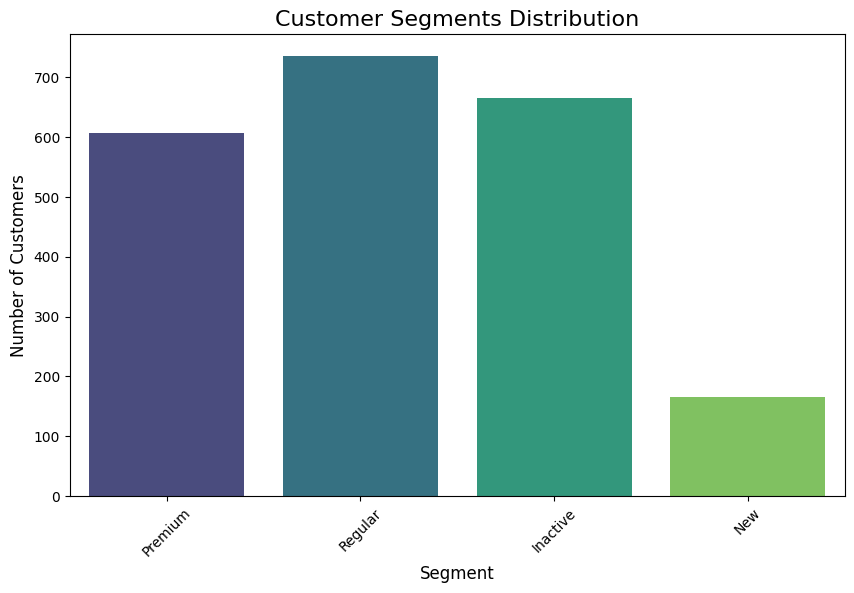

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x=rfm.Segment.value_counts().reindex(custom_order).index, y=rfm.Segment.value_counts().reindex(custom_order).values, palette="viridis")
plt.title("Customer Segments Distribution", fontsize=16)
plt.xlabel("Segment", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 8. Prepare Data

In [16]:
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

In [17]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled

array([[-1.15936644, -0.2422596 ,  0.1943974 ],
       [-0.90352771,  0.55985603,  0.8210555 ],
       [-0.27032684,  1.36197167,  2.86880724],
       ...,
       [ 2.36481213, -1.04437524, -0.75168522],
       [-0.39824621, -0.2422596 , -0.16356958],
       [-0.90352771,  1.36197167,  1.10871324]])

# 9. Modelling Customer Clusters

## K-Means Clustering


Elbow Method is a standard way to find the optimal number of clusters (k) by analyzing the within-cluster sum of squared distances (inertia).

- If k is too small, clusters contain too many dissimilar points.

- If k is too large, clusters become too specific and overfit noise.

- The elbow point balances compact clusters with minimal overlap.

### Model Validation

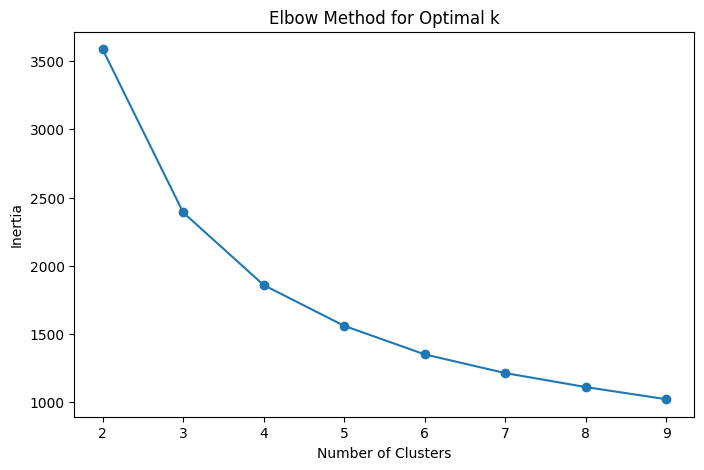

In [18]:
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [19]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment,KMeans_Cluster
customer_id,,,,,,,,,,
31813,25,2,5726.04,4,2,3,423,9,Regular,1
61020,65,3,7844.90,4,3,4,434,11,Premium,0
119099,164,4,14768.77,3,4,4,344,11,Premium,2
188838,259,2,5182.04,2,2,3,223,7,Regular,1
191616,164,2,4089.96,3,2,2,322,7,Regular,1
...,...,...,...,...,...,...,...,...,...,...
99734256,54,3,8571.89,4,4,4,444,12,Premium,0
99772709,31,3,5208.45,4,4,3,443,11,Premium,0
99784559,576,1,2527.14,1,2,2,122,5,Inactive,3


In [20]:
rfm.KMeans_Cluster.value_counts()

KMeans_Cluster
1    704
0    658
3    602
2    208
Name: count, dtype: int64

### Cluster Visualization

In [21]:
KMean_summary = rfm.groupby('KMeans_Cluster')[['R_Score', 'F_Score', 'M_Score']].mean().round(2)
KMean_summary

,R_Score,F_Score,M_Score
KMeans_Cluster,,,
0,2.88,3.42,3.40
1,3.04,1.95,1.82
2,3.31,3.98,4.00
3,1.18,1.63,1.78


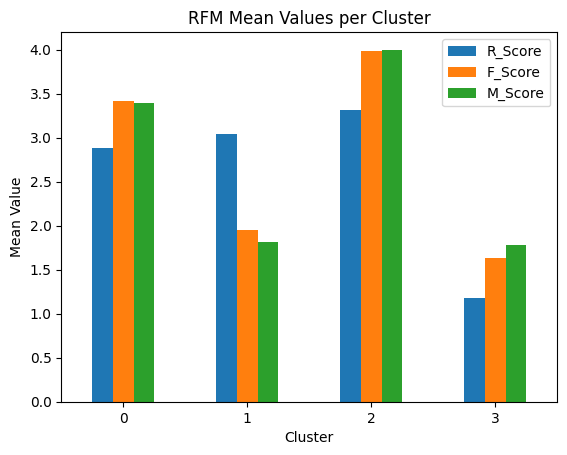

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

KMean_summary.plot(kind='bar')
plt.title('RFM Mean Values per Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

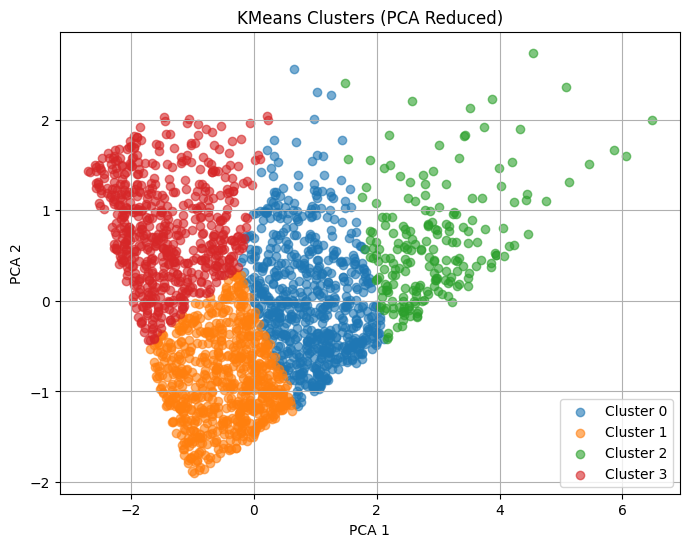

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
for cluster in np.unique(kmeans.labels_):
    plt.scatter(
        X_pca[kmeans.labels_ == cluster, 0],
        X_pca[kmeans.labels_ == cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.title('KMeans Clusters (PCA Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

## Agglomerative Clustering

Silhouette Score provides an alternative way to determine the best number of clusters.

- It calculates how similar a data point is to its own cluster vs. other clusters.

- The score ranges from -1 (poor clustering) to 1 (good clustering).

### Model Validation

In [36]:
from sklearn.metrics import silhouette_score

best_score = -1
best_k = 2
for k in range(2, 10):
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    labels = agg_clustering.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Optimal clusters for Agglomerative Clustering: {best_k} (Silhouette Score: {best_score:.4f})")

Optimal clusters for Agglomerative Clustering: 2 (Silhouette Score: 0.3178)


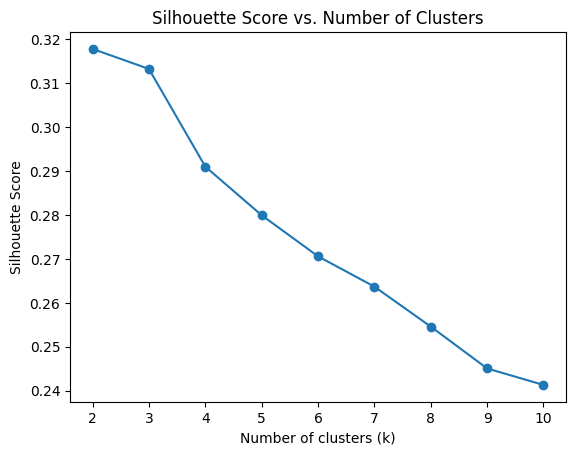

In [37]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 11):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    scores.append(score)

plt.plot(range(2, 11), scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [38]:
agg_clustering = AgglomerativeClustering(n_clusters=2)
rfm['Agglomerative_Cluster'] = agg_clustering.fit_predict(rfm_scaled)
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment,KMeans_Cluster,Agglomerative_Cluster,DBSCAN_Cluster
customer_id,,,,,,,,,,,,
31813,25,2,5726.04,4,2,3,423,9,Regular,1,0,0
61020,65,3,7844.90,4,3,4,434,11,Premium,0,0,1
119099,164,4,14768.77,3,4,4,344,11,Premium,2,0,-1
188838,259,2,5182.04,2,2,3,223,7,Regular,1,0,0
191616,164,2,4089.96,3,2,2,322,7,Regular,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99734256,54,3,8571.89,4,4,4,444,12,Premium,0,0,1
99772709,31,3,5208.45,4,4,3,443,11,Premium,0,0,1
99784559,576,1,2527.14,1,2,2,122,5,Inactive,3,1,3


In [39]:
rfm.Agglomerative_Cluster.value_counts()

Agglomerative_Cluster
0    1688
1     484
Name: count, dtype: int64

### Cluster Visualization

In [40]:
Agg_summary = rfm.groupby('Agglomerative_Cluster')[['R_Score', 'F_Score', 'M_Score']].mean().round(2)
Agg_summary

,R_Score,F_Score,M_Score
Agglomerative_Cluster,,,
0,2.90,2.81,2.75
1,1.13,1.41,1.64


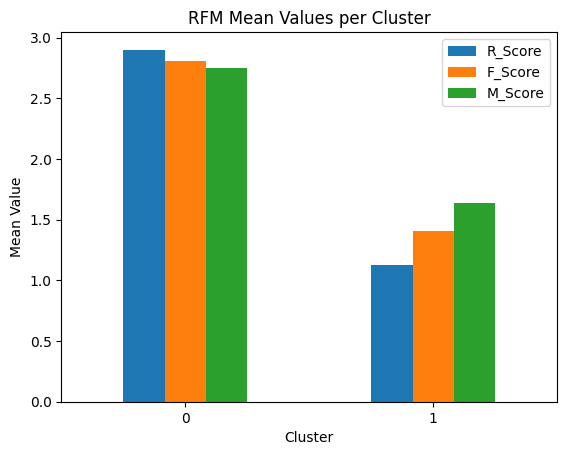

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

Agg_summary.plot(kind='bar')
plt.title('RFM Mean Values per Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

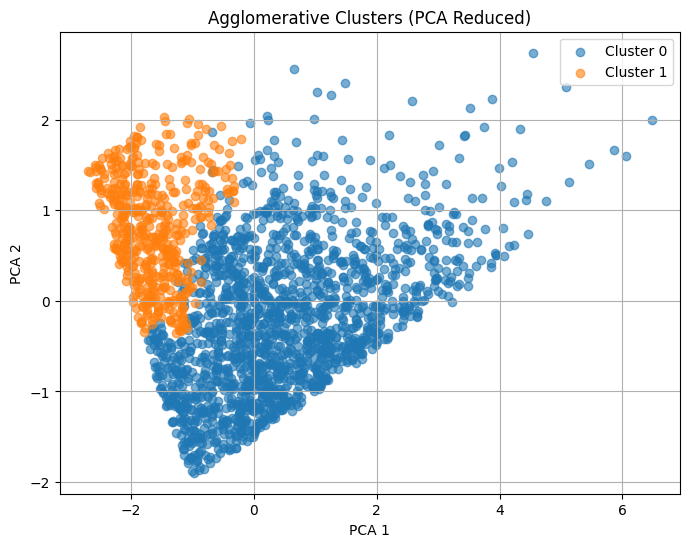

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
for cluster in np.unique(agg_clustering.labels_):
    plt.scatter(
        X_pca[agg_clustering.labels_ == cluster, 0],
        X_pca[agg_clustering.labels_ == cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.title('Agglomerative Clusters (PCA Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

## DBSCAN Clustering

The k-distance plot helps identify the ideal eps value. DBSCAN requires a min_samples parameter (minimum points in a cluster). A good rule of thumb is:

- min_samples ≈ dimensionality of data (D) + 1

- Since RFM data has 3 dimensions (Recency, Frequency, Monetary), we set min_samples=4 or 5.

- For eps, we use the (min_samples)-th nearest neighbor distance, which is why n_neighbors=5.

### Model Validation

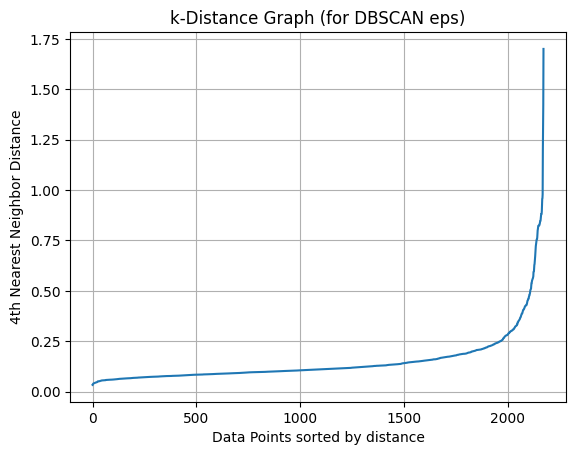

In [46]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neigh = NearestNeighbors(n_neighbors=5)  # min_samples = 5
nbrs = neigh.fit(rfm_scaled)
distances, indices = nbrs.kneighbors(rfm_scaled)

# Sort the distances to plot
distance_desc = np.sort(distances[:, 4])  # 4 because k=5 → index 4
plt.plot(distance_desc)
plt.title('k-Distance Graph (for DBSCAN eps)')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

In [47]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment,KMeans_Cluster,Agglomerative_Cluster,DBSCAN_Cluster
customer_id,,,,,,,,,,,,
31813,25,2,5726.04,4,2,3,423,9,Regular,1,0,0
61020,65,3,7844.90,4,3,4,434,11,Premium,0,0,1
119099,164,4,14768.77,3,4,4,344,11,Premium,2,0,-1
188838,259,2,5182.04,2,2,3,223,7,Regular,1,0,0
191616,164,2,4089.96,3,2,2,322,7,Regular,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99734256,54,3,8571.89,4,4,4,444,12,Premium,0,0,1
99772709,31,3,5208.45,4,4,3,443,11,Premium,0,0,1
99784559,576,1,2527.14,1,2,2,122,5,Inactive,3,1,3


In [48]:
rfm.DBSCAN_Cluster.value_counts()

DBSCAN_Cluster
 0    683
 3    678
 1    431
 4    211
-1    104
 2     50
 5     10
 6      5
Name: count, dtype: int64

### Cluster Visualization

In [49]:
DBS_summary = rfm.groupby('DBSCAN_Cluster')[['R_Score', 'F_Score', 'M_Score']].mean().round(2)
DBS_summary

,R_Score,F_Score,M_Score
DBSCAN_Cluster,,,
-1,2.51,3.78,3.57
0,2.48,2.41,2.41
1,2.93,3.42,3.24
2,3.42,4.00,4.00
3,1.94,1.20,1.43
4,3.20,4.00,3.74
5,4.00,4.00,4.00
6,4.00,4.00,4.00


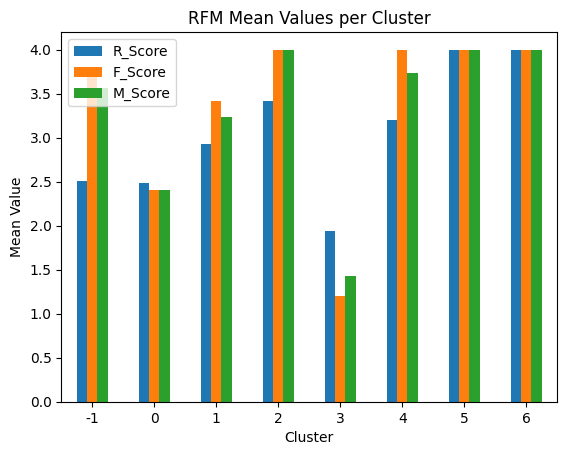

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

DBS_summary.plot(kind='bar')
plt.title('RFM Mean Values per Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

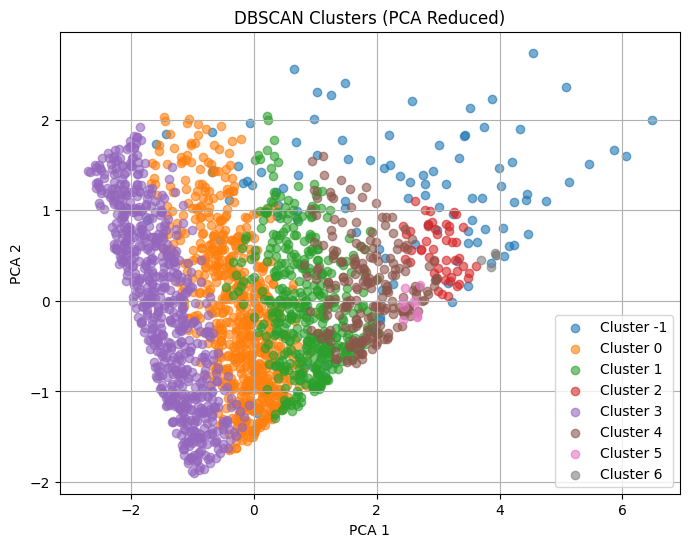

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
for cluster in np.unique(dbscan.labels_):
    plt.scatter(
        X_pca[dbscan.labels_ == cluster, 0],
        X_pca[dbscan.labels_ == cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.title('DBSCAN Clusters (PCA Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

# Model Selection

## Quantitative Evaluation (Silhouette Score)

In [52]:
from sklearn.metrics import silhouette_score

# Example for KMeans
silhouette_kmeans = silhouette_score(rfm_scaled, kmeans.labels_)

# For Agglomerative
silhouette_agglo = silhouette_score(rfm_scaled, agg_clustering.labels_)

# For DBSCAN (ignoring noise points)
dbscan_labels = dbscan.labels_
dbscan_core = rfm_scaled[dbscan_labels != -1]
silhouette_dbscan = silhouette_score(dbscan_core, dbscan_labels[dbscan_labels != -1])

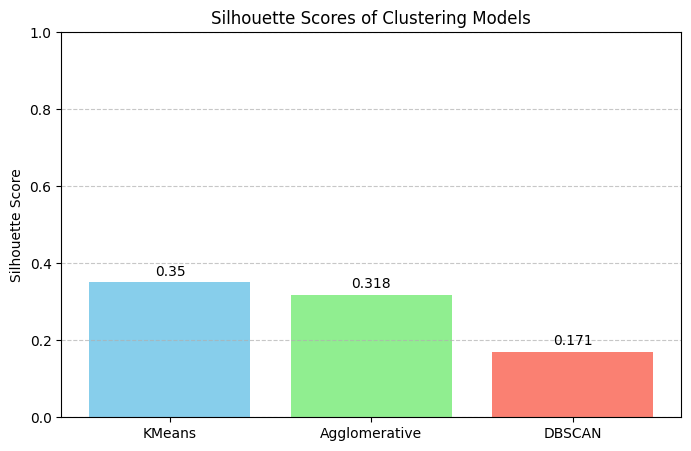

In [57]:
import matplotlib.pyplot as plt

# Labels and Scores
models = ['KMeans', 'Agglomerative', 'DBSCAN']
scores = [silhouette_kmeans, silhouette_agglo, silhouette_dbscan]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores, color=['skyblue', 'lightgreen', 'salmon'])

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.ylim(0, 1)
plt.title('Silhouette Scores of Clustering Models')
plt.ylabel('Silhouette Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Conclusion: Model Selection Based on Silhouette Scores
The silhouette score evaluates how well each data point fits within its assigned cluster compared to other clusters. It ranges from -1 (poor clustering) to 1 (well-clustered). Based on the scores:

KMeans: 0.35

Agglomerative Clustering: 0.318

DBSCAN: 0.171

KMeans achieved the highest silhouette score among the three models, suggesting it forms the most compact and well-separated clusters in this customer segmentation task.
Although Agglomerative Clustering performs closely, the simpler interpretability and tuning of KMeans (especially with a well-defined k=4 from the Elbow Method) make it a more practical choice.

On the other hand, DBSCAN yielded a lower silhouette score, indicating it struggled to form distinct clusters—likely due to the density-based nature being less suitable for this data distribution.

Recommended Model:
KMeans Clustering, based on its superior silhouette score and well-defined cluster separation.

# Model Saving

In [58]:
import joblib

joblib.dump({'model': kmeans, 'scaler': scaler}, 'kmeans_with_scaler.pkl')

['kmeans_with_scaler.pkl']

# Model Inferencing

In [64]:
cluster_definition = {0: 'Regular',
                      1: 'Inactive',
                      2: 'Premium',
                      3: 'New'}

In [59]:
import joblib

saved_objects = joblib.load('kmeans_with_scaler.pkl')

In [60]:
kmeans = saved_objects['model']
scaler = saved_objects['scaler']

In [75]:
new_data = [[4, 10, 1000]] # recency, frequency, monetary
scaled_data = scaler.transform(new_data)
scaled_data

C:\Users\Phone Myint Naing\anaconda3\envs\thai_cv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[-1.29368178,  6.1746655 , -1.20334067]])

In [76]:
predicted_cluster = kmeans.predict(scaled_data)
predicted_cluster

array([2])

In [77]:
cluster_definition[predicted_cluster[0]]

'Premium'

## Building Function

In [78]:
def predict_cluster(recency_days, frequnecy, monetary):
    new_data = [[recency_days, frequnecy, monetary]]
    scaled_data = scaler.transform(new_data)
    predicted_cluster = kmeans.predict(scaled_data)
    return cluster_definition[predicted_cluster[0]]

In [84]:
predict_cluster(20, 1, 1000)

C:\Users\Phone Myint Naing\anaconda3\envs\thai_cv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'Inactive'